# Tutorial: PyTango Microscope Control

This tutorial demonstrates how to use **PyTango** directly to interact with the microscope Tango devices.

## What You'll Learn

1. **Connection**: Connect to Tango devices using DeviceProxy
2. **Introspection**: Discover available attributes and commands
3. **Configure Detectors**: Set detector parameters
4. **Acquire Images**: Trigger image acquisition and retrieve data
5. **Device Architecture**: Understand the detector + microscope system design

## Prerequisites

Make sure the Tango servers are running:
```bash
# In a separate terminal:
python run_servers_nodb.py test -nodb -dlist DetectorDevice::test/nodb/detector_A DetectorDevice::test/nodb/detector_B DetectorDevice::test/nodb/detector_C MicroscopeSystemDevice::test/nodb/microscope --port 10000
```

## Setup & Imports

In [1]:
import tango
import numpy as np
import matplotlib.pyplot as plt

# Configure matplotlib for notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 4)

## 1. Connection to Tango Devices

The system has 4 Tango devices:
- **3 Detector Devices**: `test/nodb/detector_A`, `test/nodb/detector_B`, `test/nodb/detector_C`
- **1 Microscope System Device**: `test/nodb/microscope`

Let's connect to them using `DeviceProxy`.

In [10]:
# Connect to the microscope system device
microscope = tango.DeviceProxy("tango://localhost:10003/test/nodb/microscope#dbase=no")

# Connect to detector devices
detector_A = tango.DeviceProxy("tango://localhost:10000/test/nodb/detector_A#dbase=no")
detector_B = tango.DeviceProxy("tango://localhost:10001/test/nodb/detector_B#dbase=no")
detector_C = tango.DeviceProxy("tango://localhost:10002/test/nodb/detector_C#dbase=no")

print("✓ Connected to all devices")
print(f"  Microscope: {microscope.dev_name()}")
print(f"  Detector A: {detector_A.dev_name()}")
print(f"  Detector B: {detector_B.dev_name()}")
print(f"  Detector C: {detector_C.dev_name()}")

✓ Connected to all devices
  Microscope: test/nodb/microscope
  Detector A: test/nodb/detector_a
  Detector B: test/nodb/detector_b
  Detector C: test/nodb/detector_c


## 2. Device Introspection

PyTango provides powerful introspection capabilities. You can discover what attributes and commands are available on each device.

### 2.1 Discover Available Attributes

In [11]:
# Get all attributes for Detector A
print("=== Detector A Attributes ===")
for attr_info in detector_A.get_attribute_list():
    print(f"  - {attr_info}")

=== Detector A Attributes ===
  - active
  - dwell_time
  - resolution
  - detector_id
  - State
  - Status


### 2.2 Discover Available Commands

In [12]:
# Get all commands for Detector A
print("=== Detector A Commands ===")
for cmd_info in detector_A.get_command_list():
    print(f"  - {cmd_info}")

print("\n=== Microscope System Commands ===")
for cmd_info in microscope.get_command_list():
    print(f"  - {cmd_info}")

=== Detector A Commands ===
  - GetImage
  - Init
  - State
  - Status

=== Microscope System Commands ===
  - Connect
  - GetStage
  - Init
  - State
  - Status


### 2.3 Get Detailed Attribute Information

In [14]:
# Get detailed info about specific attributes
print("=== Detector A Attribute Details ===")
for attr_name in ['active', 'dwell_time', 'resolution', 'detector_id']:
    config = detector_A.get_attribute_config(attr_name)
    print(f"\n{attr_name}:")
    print(f"  Label: {config.label}")
    print(f"  Data type: {config.data_type}")
    print(f"  Writable: {config.writable}")
    print(f"  Description: {config.description}")
    if config.unit:
        print(f"  Unit: {config.unit}")

=== Detector A Attribute Details ===

active:
  Label: Active
  Data type: 1
  Writable: READ_WRITE
  Description: Whether this detector is active and ready for acquisition

dwell_time:
  Label: Dwell Time
  Data type: 5
  Writable: READ_WRITE
  Description: Dwell time per pixel in seconds
  Unit: s

resolution:
  Label: Resolution
  Data type: 23
  Writable: READ_WRITE
  Description: Image resolution (width and height in pixels)
  Unit: px

detector_id:
  Label: Detector ID
  Data type: 8
  Writable: READ
  Description: Detector identifier (A, B, or C)


### 2.4 Read Current Attribute Values

In [15]:
# Read current configuration of Detector A
print("=== Detector A Current Configuration ===")
print(f"Active: {detector_A.active}")
print(f"Dwell time: {detector_A.dwell_time} s")
print(f"Resolution: {detector_A.resolution} px")
print(f"Detector ID: {detector_A.detector_id}")

=== Detector A Current Configuration ===
Active: False
Dwell time: 0.1 s
Resolution: 256 px
Detector ID: A


## 3. Connect to Microscope Hardware

Before acquiring images, we need to connect the microscope system to the hardware (or simulator).

In [16]:
# Connect to microscope (in this case, a digital twin simulator)
connection_string = "localhost:9001"
result = microscope.Connect(connection_string)
print(result)

# Verify connection
print(f"\nConnected: {microscope.connected}")
print(f"Connection string: {microscope.connection_string}")

Connected to microscope at localhost:9001

Connected: True
Connection string: localhost:9001


## 4. Configure Detectors

Now let's configure a detector for image acquisition.

### 4.1 Activate Detector A

In [17]:
# Activate detector A
detector_A.active = True
print("✓ Detector A activated")

# Verify
print(f"  Active status: {detector_A.active}")

✓ Detector A activated
  Active status: True


### 4.2 Set Acquisition Parameters

In [27]:
# Set dwell time and resolution
detector_A.dwell_time = 10e-6  # 50 ms per pixel
detector_A.resolution = 128   # 128x128 image

print("✓ Acquisition parameters set")
print(f"  Dwell time: {detector_A.dwell_time} s/pixel")
print(f"  Resolution: {detector_A.resolution}x{detector_A.resolution} pixels")

# Calculate estimated acquisition time
total_time = detector_A.dwell_time * detector_A.resolution * detector_A.resolution
print(f"  Estimated acquisition time: {total_time:.2f} s")

✓ Acquisition parameters set
  Dwell time: 1e-05 s/pixel
  Resolution: 128x128 pixels
  Estimated acquisition time: 0.16 s


### 4.3 Configure Multiple Detectors

In [32]:
# Configure detector B with different settings
detector_B.active = True
detector_B.dwell_time = 10e-6
detector_B.resolution = 256

print("✓ Detector B configured")
print(f"  Resolution: {detector_B.resolution}x{detector_B.resolution}")
print(f"  Dwell time: {detector_B.dwell_time} s/pixel")

✓ Detector B configured
  Resolution: 256x256
  Dwell time: 1e-05 s/pixel


## 5. Acquire Images

Now for the exciting part - acquiring images using the `GetImage` command!

### 5.1 Single Image Acquisition

In [33]:
detector_A.set_timeout_millis(15000)  # 15s------> why this?? - 5 second timeout in device side

In [34]:
# Acquire an image from detector A
print("Acquiring image from Detector A...")
flattened_image = detector_A.GetImage()

# Reshape the flattened array to 2D
resolution = detector_A.resolution
image_a = flattened_image.reshape(resolution, resolution)

print(f"✓ Image acquired!")
print(f"  Shape: {image_a.shape}")
print(f"  Data type: {image_a.dtype}")
print(f"  Value range: [{image_a.min():.1f}, {image_a.max():.1f}]")

Acquiring image from Detector A...
✓ Image acquired!
  Shape: (128, 128)
  Data type: float64
  Value range: [0.0, 255.0]


### 5.2 Visualize the Image

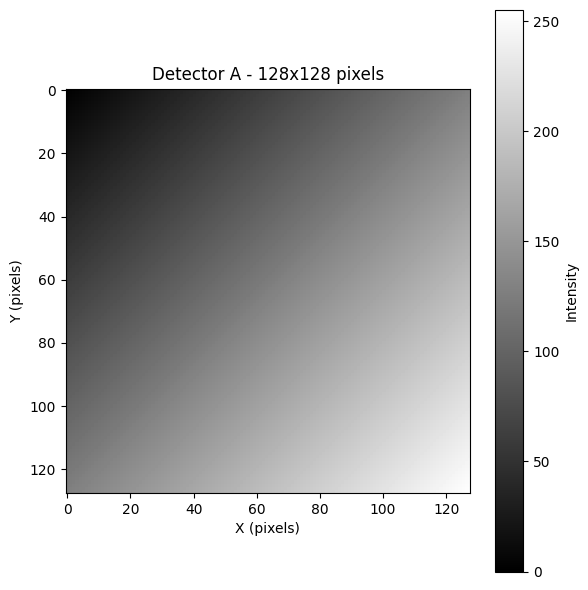

In [35]:
# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(image_a, cmap='gray')
plt.colorbar(label='Intensity')
plt.title(f'Detector A - {image_a.shape[0]}x{image_a.shape[1]} pixels')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.tight_layout()
plt.show()

### 5.3 Acquire from Multiple Detectors

In [36]:
# Acquire images from both detectors
print("Acquiring images from multiple detectors...")

# Detector A
flattened_a = detector_A.GetImage()
image_a = flattened_a.reshape(detector_A.resolution, detector_A.resolution)

# Detector B
flattened_b = detector_B.GetImage()
image_b = flattened_b.reshape(detector_B.resolution, detector_B.resolution)

print("✓ All images acquired!")
print(f"  Detector A: {image_a.shape}")
print(f"  Detector B: {image_b.shape}")

Acquiring images from multiple detectors...
✓ All images acquired!
  Detector A: (128, 128)
  Detector B: (256, 256)


### 5.4 Compare Images from Different Detectors

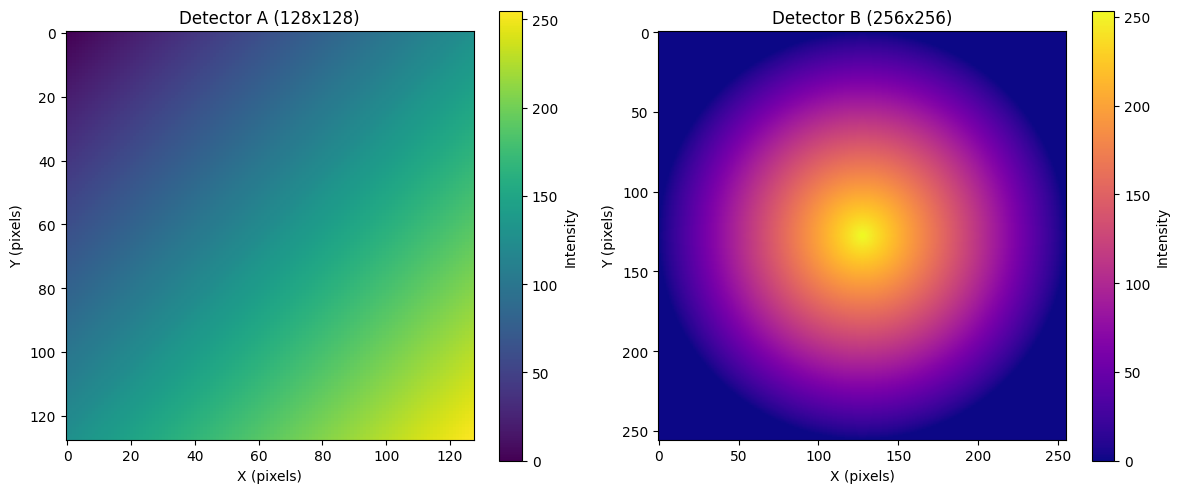

In [37]:
# Display images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Detector A
im1 = axes[0].imshow(image_a, cmap='viridis')
axes[0].set_title(f'Detector A ({image_a.shape[0]}x{image_a.shape[1]})')
axes[0].set_xlabel('X (pixels)')
axes[0].set_ylabel('Y (pixels)')
plt.colorbar(im1, ax=axes[0], label='Intensity')

# Detector B
im2 = axes[1].imshow(image_b, cmap='plasma')
axes[1].set_title(f'Detector B ({image_b.shape[0]}x{image_b.shape[1]})')
axes[1].set_xlabel('X (pixels)')
axes[1].set_ylabel('Y (pixels)')
plt.colorbar(im2, ax=axes[1], label='Intensity')

plt.tight_layout()
plt.show()

## 6. Advanced: Device State and Status

Tango devices have state and status information that's useful for monitoring.

In [39]:
# Check device state and status
print("=== Detector A State ===")
print(f"State: {detector_A.state()}")
print(f"Status: {detector_A.status()}")

print("\n=== Microscope System State ===")
print(f"State: {microscope.state()}")
print(f"Status: {microscope.status()}")

=== Detector A State ===
State: STANDBY
Status: Detector A ready.

=== Microscope System State ===
State: ON
Status: Connected to microscope at localhost:9001


## 7. System-Level Operations

The microscope system device provides system-level commands like getting stage position.

In [40]:
# Get stage position
stage_pos = microscope.GetStage()

print("=== Stage Position ===")
print(f"X: {stage_pos[0]:.3f}")
print(f"Y: {stage_pos[1]:.3f}")
print(f"Z: {stage_pos[2]:.3f}")
print(f"Tilt: {stage_pos[3]:.3f}")
print(f"Rotation: {stage_pos[4]:.3f}")

=== Stage Position ===
X: 4.118
Y: 1.961
Z: 3.448
Tilt: -6.820
Rotation: -7.524


## 8. Error Handling

PyTango raises exceptions when operations fail. Let's see how to handle them.

In [41]:
# Try to acquire from an inactive detector
detector_C.active = False

try:
    image = detector_C.GetImage()
except tango.DevFailed as e:
    print("❌ Error caught:")
    for err in e.args:
        print(f"  Reason: {err.reason}")
        print(f"  Description: {err.desc}")

❌ Error caught:
  Reason: PyDs_PythonError
  Description: Exception: Detector C is not active. Set active = True first.

  Reason: PyDs_UnexpectedFailure
  Description: Cannot execute command
  Reason: API_CommandFailed
  Description: Failed to execute command_inout on device test/nodb/detector_c, command GetImage


## 9. Programmatic Detector Access

You can work with detectors programmatically using dictionaries.

In [42]:
# Create a dictionary of detectors
detectors = {
    'A': detector_A,
    'B': detector_B,
    'C': detector_C
}

# Loop through all detectors
print("=== All Detectors Status ===")
for det_id, detector in detectors.items():
    print(f"\nDetector {det_id}:")
    print(f"  Active: {detector.active}")
    if detector.active:
        print(f"  Resolution: {detector.resolution}x{detector.resolution}")
        print(f"  Dwell time: {detector.dwell_time} s")

=== All Detectors Status ===

Detector A:
  Active: True
  Resolution: 128x128
  Dwell time: 1e-05 s

Detector B:
  Active: True
  Resolution: 256x256
  Dwell time: 1e-05 s

Detector C:
  Active: False


## 10. Summary

### What We Learned

1. **DeviceProxy**: Connect to Tango devices using `tango.DeviceProxy()`
2. **Introspection**: Discover attributes and commands with `get_attribute_list()` and `get_command_list()`
3. **Attributes**: Read/write attributes directly as properties (e.g., `detector.active = True`)
4. **Commands**: Call commands as methods (e.g., `detector.GetImage()`)
5. **Error Handling**: Catch `tango.DevFailed` exceptions
6. **Architecture**: Separate detector devices + main microscope system

### Key PyTango Patterns

```python
# Connect to device
device = tango.DeviceProxy("tango://host:port/domain/family/member#dbase=no")

# Read attribute
value = device.attribute_name

# Write attribute
device.attribute_name = new_value

# Call command
result = device.CommandName(args)

# Get state/status
state = device.state()
status = device.status()
```

### Architecture Benefits

- **Separation of Concerns**: Each detector is its own device
- **Scalability**: Easy to add more detectors
- **Flexibility**: Configure each detector independently
- **Clean API**: Simple, direct PyTango interface

## Cleanup

In [43]:
# Deactivate detectors when done
detector_A.active = False
detector_B.active = False
detector_C.active = False

print("✓ All detectors deactivated")

✓ All detectors deactivated
